In [74]:
!pip install optuna

In [75]:
import json

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%config InlineBackend.figure_format = 'svg'

In [76]:
torch.manual_seed(0)
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


In [77]:
DATASET = "eimi"

In [78]:
df = pd.read_csv(f"./data/raw/{DATASET}.csv", parse_dates=True)

<Axes: title={'center': 'eimi'}>

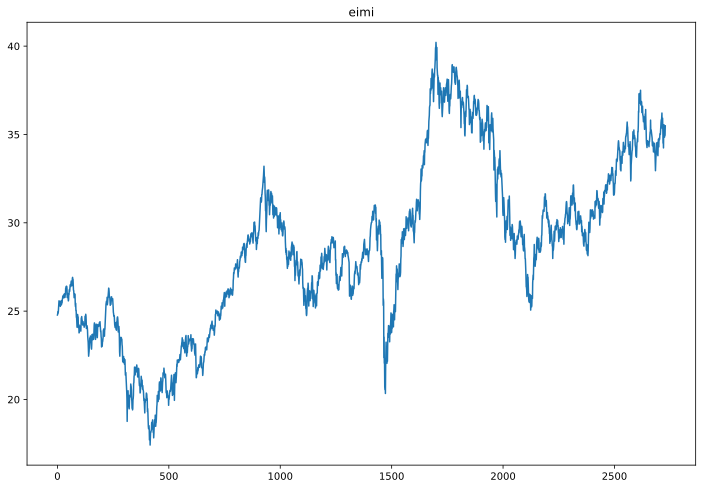

In [79]:
df["Close"].plot(title=f"{DATASET}", figsize=(12, 8))

In [80]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [81]:
Xy_train_val, Xy_test = train_test_split(
    df["Close"].values, test_size=0.2, shuffle=False
)
Xy_train, Xy_val = train_test_split(Xy_train_val, test_size=0.25, shuffle=False)

In [82]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers,dropout):
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_layer_size = hidden_layer_size
        self.gru = nn.GRU(
            input_size, hidden_layer_size, num_layers=num_layers, batch_first=True,dropout=dropout
        )
        self.fc = nn.Linear(hidden_layer_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [83]:
def to_tensor(data):
    return torch.tensor(data, dtype=torch.float32).unsqueeze(-1).to(device)

In [84]:
def create_sequences(data, window_size):
    xs, ys = [], []
    for i in range(len(data) - window_size):
        x = data[i : (i + window_size)]
        y = data[i + window_size]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [85]:
# Hyperparameter tuning
def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 16, 128)
    # num_layers = trial.suggest_int("num_layers", 1, 4)
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    epochs = trial.suggest_int("epochs", 100, 1000)
    num_inputs = trial.suggest_int("num_inputs", 5, 30)
    dropout = trial.suggest_float("dropout",0,0.5)

    model = GRU(1, hidden_layer_size=hidden_size, num_layers=2,dropout=dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    X_train, y_train = create_sequences(Xy_train, window_size=num_inputs)
    X_val, y_val = create_sequences(Xy_val, window_size=num_inputs)

    X_train = to_tensor(x_scaler.fit_transform(X_train))
    X_val = to_tensor(x_scaler.transform(X_val))

    y_train = to_tensor(y_scaler.fit_transform(y_train.reshape(-1, 1)).reshape(-1))
    y_val = to_tensor(y_scaler.transform(y_val.reshape(-1, 1)).reshape(-1))

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        train_output = model(X_train)
        train_loss = criterion(train_output, y_train)

        train_loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            model.eval()
            with torch.no_grad():
                val_output = model(X_val)
                val_loss = criterion(val_output, y_val)
            trial.report(val_loss.item(), epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    # Compute final validation loss after training completes
    model.eval()
    with torch.no_grad():
        final_val_output = model(X_val)
        final_val_loss = criterion(final_val_output, y_val)

    return final_val_loss.item()

In [86]:
def train_model(hyperparams, X_train, y_train, X_test, y_test):
    hidden_size = hyperparams["hidden_size"]
    # num_layers = hyperparams["num_layers"]
    learning_rate = hyperparams["lr"]
    epochs = hyperparams["epochs"]
    dropout = hyperparams['dropout']

    model = GRU(1, hidden_layer_size=hidden_size, num_layers=2,dropout=dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        train_loss = loss(y_pred, y_train)
        train_loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            model.eval()
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss(y_test_pred, y_test)
            print(
                f"Epoch {epoch}, Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}"
            )
    return model

In [87]:
sampler = optuna.samplers.TPESampler(seed=0)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=50)

[I 2025-03-31 23:40:45,273] A new study created in memory with name: no-name-b31d8e59-dbfe-471a-8ea8-30739e64368d
[I 2025-03-31 23:40:47,530] Trial 0 finished with value: 0.002578961430117488 and parameters: {'hidden_size': 78, 'lr': 0.0013981961408994052, 'epochs': 643, 'num_inputs': 19, 'dropout': 0.21182739966945235}. Best is trial 0 with value: 0.002578961430117488.
[I 2025-03-31 23:40:52,330] Trial 1 finished with value: 0.0016327742487192154 and parameters: {'hidden_size': 88, 'lr': 0.00020547625125911338, 'epochs': 903, 'num_inputs': 30, 'dropout': 0.19172075941288885}. Best is trial 1 with value: 0.0016327742487192154.
[I 2025-03-31 23:40:55,726] Trial 2 finished with value: 0.0011710210237652063 and parameters: {'hidden_size': 105, 'lr': 0.0003860866271460546, 'epochs': 611, 'num_inputs': 29, 'dropout': 0.03551802909894347}. Best is trial 2 with value: 0.0011710210237652063.
[I 2025-03-31 23:40:58,138] Trial 3 finished with value: 0.255158931016922 and parameters: {'hidden_siz

In [88]:
params = study.best_params
num_inputs = params["num_inputs"]

In [89]:
with open(f"./models/{DATASET}_hyperparams.json", "w") as f:
    json.dump(params, f, indent=4)

In [90]:
X_train_val, y_train_val = create_sequences(Xy_train_val, window_size=num_inputs)
X_train_val = x_scaler.fit_transform(X_train_val)
y_train_val = y_scaler.fit_transform(y_train_val.reshape(-1, 1)).reshape(-1)

X_test, y_test = create_sequences(Xy_test, window_size=num_inputs)
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test.reshape(-1, 1)).reshape(-1)

In [91]:
gru = train_model(
    params,
    to_tensor(X_train_val),
    to_tensor(y_train_val),
    to_tensor(X_test),
    to_tensor(y_test),
)

Epoch 0, Train Loss: 0.2447, Test Loss: 0.0796
Epoch 100, Train Loss: 0.0004, Test Loss: 0.0003
Epoch 200, Train Loss: 0.0003, Test Loss: 0.0002
Epoch 300, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 400, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 500, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 600, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 700, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 800, Train Loss: 0.0002, Test Loss: 0.0002


RMSE: 0.3117


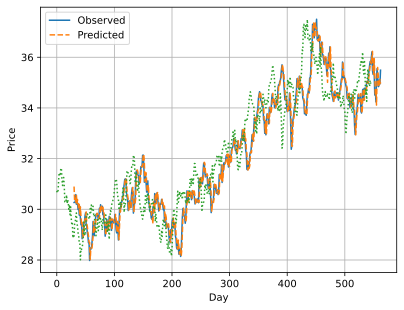

In [93]:
points = []
for i in range(len(X_test)):
    input_seq = (
        torch.tensor(X_test[i, :], dtype=torch.float32)
        .to(device)
        .unsqueeze(-1)
        .unsqueeze(0)
    )
    value = gru(input_seq)
    points.append(value.cpu().item())
points = y_scaler.inverse_transform(np.array(points).reshape(-1, 1))
rmse = root_mean_squared_error(
    points, y_scaler.inverse_transform(y_test.reshape(-1, 1))
)
print(f"RMSE: {rmse:.4f}")
import pickle
with open(f'{DATASET}_arima.pkl','rb') as f:
  ari_points = pickle.load(f)
plt.plot(range(30,len(y_test)+30),y_scaler.inverse_transform(y_test.reshape(-1, 1)), label="Observed")
plt.plot(range(30,len(y_test)+30),points, "--", label="Predicted")
plt.plot(range(len(ari_points)),ari_points,':')
plt.grid()
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.savefig(f'./images/{DATASET}_gru.png',bbox_inches='tight')

In [94]:
torch.save(gru, f"./models/gru_{DATASET}.pt")